### Deep Learning project using `Weather Image Recognition` dataset  

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os

In [2]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense , Conv2D , MaxPool2D , AveragePooling2D , Flatten , GlobalAveragePooling2D
from keras.layers import BatchNormalization , Dropout
from keras.layers import Input , Activation
from keras.losses import BinaryCrossentropy , CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report , confusion_matrix
from keras.applications import resnet50 , ResNet50 , VGG16
from keras.optimizers import Adam , Adamax

# 2. Load the dataset

In [37]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 3.0 MB/s eta 0:00:00


In [49]:
import patoolib

patoolib.extract_archive('/content/drive/MyDrive/Copy_of_archive.zip')

INFO patool: Extracting /content/drive/MyDrive/Copy_of_archive.zip ...
INFO:patool:Extracting /content/drive/MyDrive/Copy_of_archive.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_tjwfyyse -- /content/drive/MyDrive/Copy_of_archive.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_tjwfyyse -- /content/drive/MyDrive/Copy_of_archive.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/drive/MyDrive/Copy_of_archive.zip extracted to `dataset'.
INFO:patool:... /content/drive/MyDrive/Copy_of_archive.zip extracted to `dataset'.


'dataset'

In [51]:
image_paths = []
labels = []

for folder_name in os.listdir('/content/dataset'):
    folder_path = os.path.join('/content/dataset', folder_name)
    for filename in os.listdir(folder_path):
                image_path = os.path.join(folder_path, filename)
                image_paths.append(image_path)
                labels.append(folder_name)

data = pd.DataFrame({'image_path': image_paths, 'label': labels})

In [52]:
data.sample(5)

,image_path,label
1081,/content/dataset/sandstorm/3362.jpg,sandstorm
3883,/content/dataset/glaze/6689.jpg,glaze
2648,/content/dataset/dew/2224.jpg,dew
5238,/content/dataset/rime/5302.jpg,rime
3084,/content/dataset/snow/0977.jpg,snow


# 3. split the data into train ,validate & test

In [53]:
X_train , X_test , y_train , y_test = train_test_split(data['image_path'] ,data['label'] ,test_size=0.2 , shuffle=True , random_state=42)

In [54]:
X_train , X_val , y_train , y_val = train_test_split(X_train, y_train , test_size= 0.2 , shuffle=True , random_state=42)

In [55]:
train_df = pd.concat([X_train , y_train] , axis=1)
train_df.head()

,image_path,label
2109,/content/dataset/hail/0073.jpg,hail
2610,/content/dataset/dew/2904.jpg,dew
1590,/content/dataset/hail/0331.jpg,hail
152,/content/dataset/frost/3789.jpg,frost
3304,/content/dataset/snow/1094.jpg,snow


In [56]:
train_df.shape

(4391, 2)

In [57]:
test_df = pd.concat([X_test , y_test] , axis= 1 )
test_df.head()

,image_path,label
5828,/content/dataset/rime/6084.jpg,rime
1670,/content/dataset/hail/0099.jpg,hail
3184,/content/dataset/snow/1344.jpg,snow
6254,/content/dataset/fogsmog/4911.jpg,fogsmog
132,/content/dataset/frost/3602.jpg,frost


In [58]:
test_df.shape

(1373, 2)

In [59]:
validation_df = pd.concat([X_val , y_val] , axis=1)
validation_df.head()

,image_path,label
2508,/content/dataset/dew/2505.jpg,dew
2957,/content/dataset/snow/1416.jpg,snow
4024,/content/dataset/glaze/6587.jpg,glaze
1435,/content/dataset/sandstorm/3173.jpg,sandstorm
953,/content/dataset/sandstorm/3235.jpg,sandstorm


In [16]:
validation_df.shape

(579, 2)

In [60]:
BATCH_SIZE = 32
NUM_CLASSES = len(data['label'].unique())     #num of classes
EPOCHS = 50
RANDOM_SEED = 1234
IMG_SIZE = (224 , 224)
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE[0] , IMG_SIZE[1] , CHANNELS)

### we need data augmentation ( create image data-generator )

In [61]:
train_img_generator = ImageDataGenerator(rotation_range = 20,
                                         width_shift_range= 0.2 ,
                                         height_shift_range= 0.2 ,
                                         shear_range= 0.2 ,
                                         brightness_range=[1.0, 0.8],
                                         zoom_range= 0.2 ,
                                         horizontal_flip= True ,
                                         rescale= 1. / 255. )

valid_img_generator = ImageDataGenerator(rescale=1./255.)
test_img_generator = ImageDataGenerator(rescale= 1. / 255.)

In [62]:
train_generator = train_img_generator.flow_from_dataframe(dataframe= train_df,
                                                          x_col= 'image_path',
                                                          y_col= 'label',
                                                          target_size= IMG_SIZE,
                                                          color_mode='rgb',
                                                          class_mode='categorical',
                                                          shuffle=True,
                                                          batch_size= BATCH_SIZE,
                                                          seed= RANDOM_SEED)

valid_generator = valid_img_generator.flow_from_dataframe(dataframe= validation_df,
                                                          x_col= 'image_path',
                                                          y_col= 'label',
                                                          target_size= IMG_SIZE,
                                                          color_mode='rgb',
                                                          class_mode='categorical',
                                                          shuffle=True,
                                                          batch_size= BATCH_SIZE,
                                                          seed= RANDOM_SEED)

test_generator = test_img_generator.flow_from_dataframe(dataframe= test_df,
                                                       x_col='image_path',
                                                       y_col= 'label' ,
                                                       class_mode='categorical',
                                                       target_size= IMG_SIZE,
                                                       shuffle =  True ,
                                                       batch_size= BATCH_SIZE ,
                                                       seed= RANDOM_SEED)

Found 4391 validated image filenames belonging to 11 classes.
Found 1098 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.


# 4. Display sample of the data

In [63]:
train_generator.class_indices

{'dew': 0,
 'fogsmog': 1,
 'frost': 2,
 'glaze': 3,
 'hail': 4,
 'lightning': 5,
 'rain': 6,
 'rainbow': 7,
 'rime': 8,
 'sandstorm': 9,
 'snow': 10}

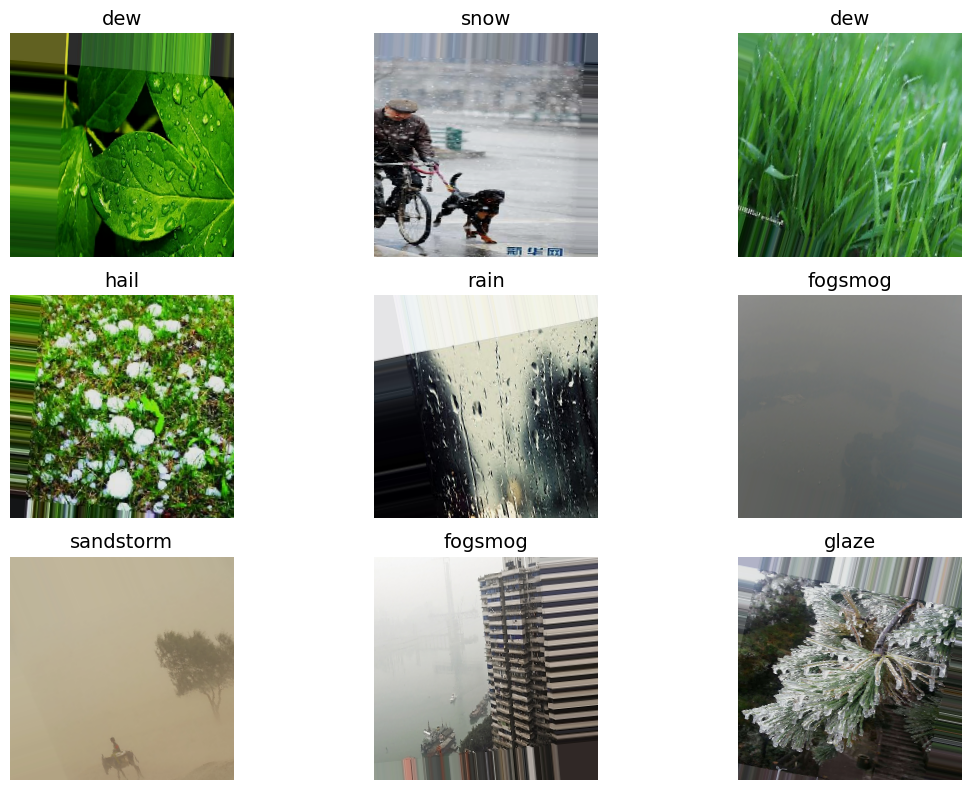

In [64]:
classes = list(train_generator.class_indices.keys())
images , labels = next(train_generator)

plt.figure(figsize=(12,8))
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(images[i])
    plt.title(classes[np.argmax(labels[i])] , fontdict={'fontsize' : 14 , 'color': 'black'})
    plt.axis('off')

plt.tight_layout()
plt.show();

# 4.Model building :
#### using pre-trained model for transfer learning using `VGG16` & `ResNet50`

In [ ]:
base_model = VGG16(include_top = False, weights='imagenet', input_shape=IMG_SHAPE , pooling='max')
for layer in base_model.layers:           #freeze the pre_trained so thier weights don't be updated during training
    layer.trainable = False   #our dataset is small so it's suitable

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Dense(256 , activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES , activation='softmax'))

In [ ]:
model.compile(optimizer=Adam() , loss='categorical_crossentropy' , metrics=['accuracy'] )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 11)                2827      
                                                                 
Total params: 14850891 (56.65 MB)
Trainable params: 135179 (528.04 KB)
Non-trainable params: 14715712 (56.14 MB)
_________

In [ ]:
train_hist = model.fit(x=train_generator ,batch_size=BATCH_SIZE,epochs=EPOCHS , validation_data= valid_generator )

Epoch 1/50
138/138 [==============================] - 120s 785ms/step - loss: 1.3701 - accuracy: 0.5438 - val_loss: 1.1002 - val_accuracy: 0.6412
Epoch 2/50
138/138 [==============================] - 105s 760ms/step - loss: 0.9344 - accuracy: 0.6773 - val_loss: 0.7913 - val_accuracy: 0.7322
Epoch 3/50
138/138 [==============================] - 103s 747ms/step - loss: 0.8432 - accuracy: 0.7137 - val_loss: 0.7251 - val_accuracy: 0.7404
Epoch 4/50
138/138 [==============================] - 103s 742ms/step - loss: 0.7896 - accuracy: 0.7197 - val_loss: 0.7685 - val_accuracy: 0.7450
Epoch 5/50
138/138 [==============================] - 103s 747ms/step - loss: 0.7389 - accuracy: 0.7390 - val_loss: 0.7186 - val_accuracy: 0.7741
Epoch 6/50
138/138 [==============================] - 103s 745ms/step - loss: 0.6958 - accuracy: 0.7481 - val_loss: 0.7383 - val_accuracy: 0.7623
Epoch 7/50
138/138 [==============================] - 105s 765ms/step - loss: 0.6718 - accuracy: 0.7663 - val_loss: 0.7125 -

# 5.Model Evaluation

In [ ]:
train_score = model.evaluate(train_generator)
valid_score = model.evaluate(valid_generator)
test_score = model.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

43/43 [==============================] - 16s 378ms/step - loss: 0.6458 - accuracy: 0.7968
Train Loss:  0.25879377126693726
Train Accuracy:  0.912092924118042
--------------------
Validation Loss:  0.7270042300224304
Validation Accuracy:  0.7887067198753357
--------------------
Test Loss:  0.6458271741867065
Test Accuracy:  0.7967953681945801


In [ ]:
training_acc =train_hist.history['accuracy']
training_loss = train_hist.history['loss']
val_acc = train_hist.history['val_accuracy']
val_loss = train_hist.history['val_loss']

# 6. Visualize results

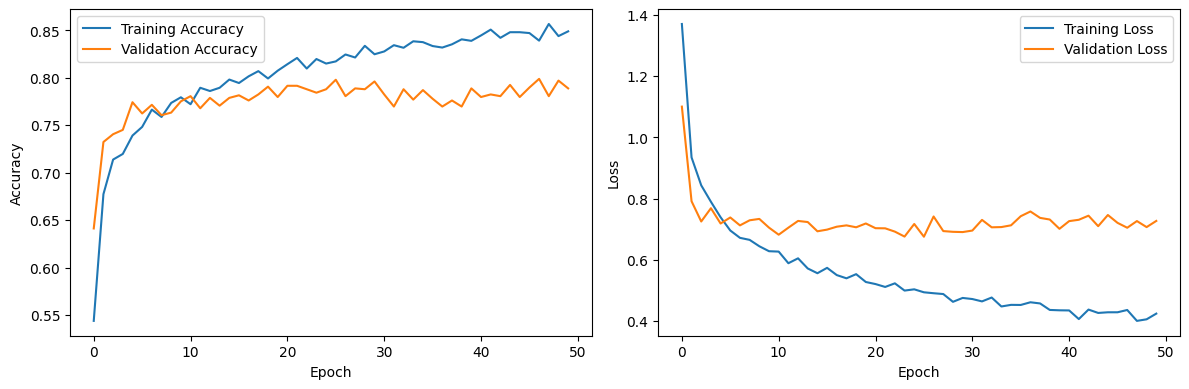

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_acc, label='Training Accuracy', color='tab:blue')
plt.plot(val_acc, label='Validation Accuracy', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss', color='tab:blue')
plt.plot(val_loss, label='Validation Loss', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show();

In [ ]:
preds = model.predict_generator(test_generator)
y_pred = np.argmax(preds, axis=1)

<ipython-input-32-aae48f26bcd4>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator)


In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

         dew       0.13      0.13      0.13       156
     fogsmog       0.13      0.12      0.12       169
       frost       0.09      0.09      0.09        91
       glaze       0.08      0.09      0.08       122
        hail       0.09      0.09      0.09       127
   lightning       0.06      0.06      0.06        80
        rain       0.13      0.10      0.12       105
     rainbow       0.05      0.04      0.04        52
        rime       0.20      0.20      0.20       221
   sandstorm       0.07      0.07      0.07       123
        snow       0.07      0.08      0.07       127

    accuracy                           0.11      1373
   macro avg       0.10      0.10      0.10      1373
weighted avg       0.11      0.11      0.11      1373



# 7. Save the model

In [ ]:
model.save('VGG16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/VGG16.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.01), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/drive/MyDrive/dataset/dataset/snow/0868.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 2s 2s/step
snow


### using `ResNet50`

In [65]:
base_model_2 = ResNet50(weights='imagenet', include_top=False)

for layer in base_model_2.layers:
    layer.trainable = False


In [66]:
model_2 = Sequential()
model_2.add(base_model_2)
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(GlobalAveragePooling2D())
model_2.add(Dense(NUM_CLASSES, activation='softmax'))

In [67]:
model_2.compile(optimizer=Adam() , loss='categorical_crossentropy' , metrics=['accuracy'] )
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 dense_6 (Dense)             (None, None, None, 256)   524544    
                                                                 
 dropout_3 (Dropout)         (None, None, None, 256)   0         
                                                                 
 global_average_pooling2d_3  (None, 256)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 11)                2827      
                                                                 
Total params: 24115083 (91.99 MB)
Trainable params: 52

In [70]:
early_stop = EarlyStopping(monitor='val_accuracy' , patience= 6 , restore_best_weights= True )

In [71]:
train_hist_2 = model_2.fit(x=train_generator ,batch_size=64,epochs=20 , validation_data= valid_generator , callbacks=[early_stop])

Epoch 1/20
138/138 [==============================] - 86s 620ms/step - loss: 1.9466 - accuracy: 0.2858 - val_loss: 1.8147 - val_accuracy: 0.3097
Epoch 2/20
138/138 [==============================] - 84s 606ms/step - loss: 1.8913 - accuracy: 0.3004 - val_loss: 1.7885 - val_accuracy: 0.3033
Epoch 3/20
138/138 [==============================] - 85s 616ms/step - loss: 1.8657 - accuracy: 0.3150 - val_loss: 1.7339 - val_accuracy: 0.3352
Epoch 4/20
138/138 [==============================] - 82s 597ms/step - loss: 1.8349 - accuracy: 0.3204 - val_loss: 1.7149 - val_accuracy: 0.3643
Epoch 5/20
138/138 [==============================] - 84s 610ms/step - loss: 1.7959 - accuracy: 0.3459 - val_loss: 1.7530 - val_accuracy: 0.3552
Epoch 6/20
138/138 [==============================] - 88s 636ms/step - loss: 1.7905 - accuracy: 0.3550 - val_loss: 1.9205 - val_accuracy: 0.2832
Epoch 7/20
138/138 [==============================] - 84s 610ms/step - loss: 1.7624 - accuracy: 0.3553 - val_loss: 1.6922 - val_ac

In [72]:
train_score = model_2.evaluate(train_generator)
valid_score = model_2.evaluate(valid_generator)
test_score = model_2.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

43/43 [==============================] - 8s 182ms/step - loss: 1.5592 - accuracy: 0.4399
Train Loss:  1.5851970911026
Train Accuracy:  0.44090184569358826
--------------------
Validation Loss:  1.549797534942627
Validation Accuracy:  0.43989071249961853
--------------------
Test Loss:  1.5592411756515503
Test Accuracy:  0.4399125874042511


In [73]:
training_acc =train_hist_2.history['accuracy']
training_loss = train_hist_2.history['loss']
val_acc = train_hist_2.history['val_accuracy']
val_loss = train_hist_2.history['val_loss']

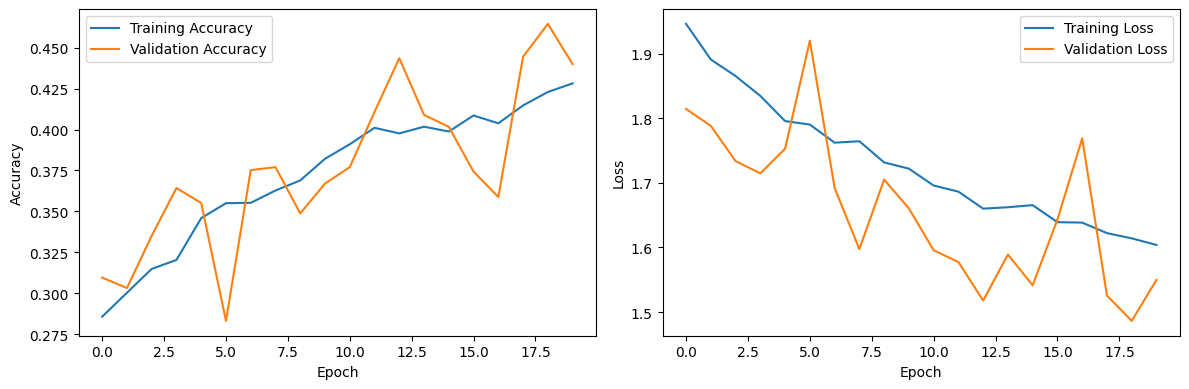

In [74]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_acc, label='Training Accuracy', color='tab:blue')
plt.plot(val_acc, label='Validation Accuracy', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss', color='tab:blue')
plt.plot(val_loss, label='Validation Loss', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show();

In [75]:
preds = model_2.predict_generator(test_generator)
y_pred = np.argmax(preds, axis=1)

<ipython-input-75-90f84860496a>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model_2.predict_generator(test_generator)


In [76]:
print(classification_report(test_generator.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

         dew       0.08      0.09      0.08       129
     fogsmog       0.12      0.16      0.13       174
       frost       0.07      0.04      0.05       111
       glaze       0.11      0.06      0.08       134
        hail       0.08      0.20      0.12       112
   lightning       0.13      0.11      0.12        74
        rain       0.11      0.05      0.07        92
     rainbow       0.00      0.00      0.00        42
        rime       0.19      0.37      0.25       222
   sandstorm       0.18      0.04      0.07       138
        snow       0.09      0.02      0.03       145

    accuracy                           0.13      1373
   macro avg       0.11      0.10      0.09      1373
weighted avg       0.12      0.13      0.11      1373



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
